# MNIST 기본 과제

이번 과제에서는 MNIST를 regression mo*-del이 아닌 classification model로 구현합니다. 그리고 train과 test data에 대한 모델의 정확도를 plot하여 generalization error를 살펴봅니다.

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다.
train param을 통해 trainset과 testset을 분리해서 다운받을 수 있다

In [9]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

trainset과 testset의 데이터 요약을 프린트함

[INFO] trainset len : 60000
[INFO] trainset shape : torch.Size([1, 28, 28])
[INFO] trainset 1st data : 5
AxesImage(shape=(28, 28))


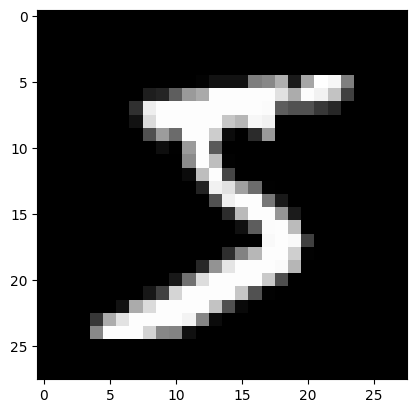

In [10]:
from matplotlib import pyplot as plt

print(f"[INFO] trainset len : {len(trainset)}")
print(f"[INFO] trainset shape : {trainset[0][0].shape}")
print(f"[INFO] trainset 1st data : {trainset[0][1]}")
print(plt.imshow(trainset[0][0][0], cmap='gray'))

[INFO] testset len : 10000
[INFO] testset shape : torch.Size([1, 28, 28])
[INFO] testset 1st data : 7
AxesImage(shape=(28, 28))


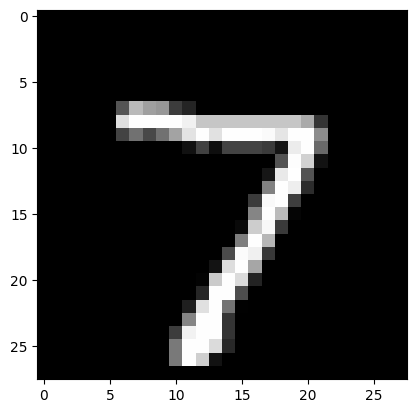

In [11]:
print(f"[INFO] testset len : {len(testset)}")
print(f"[INFO] testset shape : {testset[0][0].shape}")
print(f"[INFO] testset 1st data : {testset[0][1]}")
print(plt.imshow(testset[0][0][0], cmap='gray'))

위 출력 결과를 통해 testset과 dataset의 개수와 예시를 알 수 있었다.

아래 과정을 통해 SGD 에 필요하도록 batch size를 넣어서 loader를 구현했고, test_data는 shuffle을 False로 두어 섞이지 않도록 했다.

In [12]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

In [13]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

#### 과제 변경점

다음은 (n, 1, 28, 28) shape의 image를 입력받아 학습하는 모델을 만들어야하는데, 다만 지금은 classifier 모델을 만들 것 이므로 출력 차원을 10으로 만들어야 함.

MNIST는 0~9까지 10개의 데이터로 classify 하는 모델이기 때문..!
마지막 출력차원을 10으로 값을 고정해줘야한다.

그리고 마지막layer를 loss를 계산하기 위해 softmax를 사용해줘야 할 것 같

In [14]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

In [15]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

어떤 dataloader에 대한 model의 정확도를 측정하는 코드는 다음 함수를 사용하시면 됩니다:

In [17]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1) #가장 높은 점수의 class index 선

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [18]:
n_epochs = 100
loss_function = nn.CrossEntropyLoss()

train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = loss_function(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_accuracy.append(accuracy(model, trainloader))
  test_accuracy.append(accuracy(model, testloader))
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 1701.1823058128357
Epoch   1 | Loss: 1548.9454630613327
Epoch   2 | Loss: 1420.488335609436
Epoch   3 | Loss: 1319.9984084367752
Epoch   4 | Loss: 1242.0286822915077
Epoch   5 | Loss: 1181.5687093138695
Epoch   6 | Loss: 1134.1757454872131
Epoch   7 | Loss: 1096.1010156273842
Epoch   8 | Loss: 1064.931885778904
Epoch   9 | Loss: 1039.292270720005
Epoch  10 | Loss: 1017.8069027662277
Epoch  11 | Loss: 999.7520169615746
Epoch  12 | Loss: 984.2711514234543
Epoch  13 | Loss: 971.0525387525558
Epoch  14 | Loss: 959.9650185108185
Epoch  15 | Loss: 950.0790750980377
Epoch  16 | Loss: 941.3376605510712
Epoch  17 | Loss: 933.6616029143333
Epoch  18 | Loss: 927.0780718326569
Epoch  19 | Loss: 920.7826083302498
Epoch  20 | Loss: 915.3740813732147
Epoch  21 | Loss: 910.1813960075378
Epoch  22 | Loss: 905.4991443753242
Epoch  23 | Loss: 901.3629570007324
Epoch  24 | Loss: 897.4032746553421
Epoch  25 | Loss: 893.7425600588322
Epoch  26 | Loss: 890.4253905415535
Epoch  27 | Loss: 88

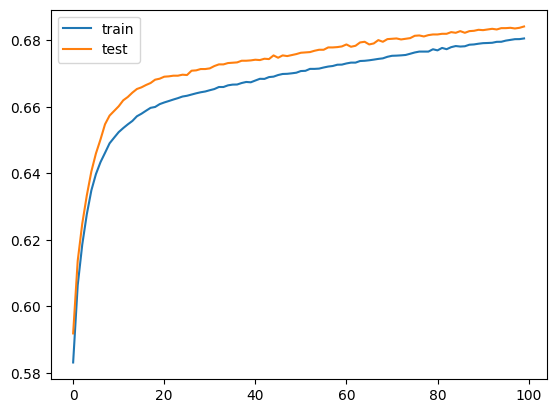

In [22]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_accuracy, test_accuracy)

### 2번째 모델 (개인학습)
이론을 보면 마지막에 sigmoid로 loss가 계산되기 때문에 relu가 필요 없어보임.
아니 오히려 음수를 제거해서 성능이 안좋아질 것 같음

relu를 뺐을때 학습이 어떻게 되는지 비교해보고자한다.

In [24]:
from torch import nn


class Model2(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x) ## 마지막에 act 제거

    return x


model2 = Model2(28 * 28 * 1, 1024)

In [27]:
lr = 0.001
model2 = model2.to('cuda')

optimizer = SGD(model2.parameters(), lr=lr)

In [28]:
n_epochs = 100
loss_function = nn.CrossEntropyLoss()

train_accuracy = []
test_accuracy = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model2.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model2(inputs)
    loss = loss_function(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  train_accuracy.append(accuracy(model2, trainloader))
  test_accuracy.append(accuracy(model2, testloader))
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 2125.5058104991913
Epoch   1 | Loss: 2047.3193619251251
Epoch   2 | Loss: 1919.7570799589157
Epoch   3 | Loss: 1702.6039134263992
Epoch   4 | Loss: 1398.5246274471283
Epoch   5 | Loss: 1101.8093925714493
Epoch   6 | Loss: 886.6548193693161
Epoch   7 | Loss: 745.8592165708542
Epoch   8 | Loss: 651.9011164009571
Epoch   9 | Loss: 586.1044919788837
Epoch  10 | Loss: 537.6129494607449
Epoch  11 | Loss: 500.58635142445564
Epoch  12 | Loss: 471.6141185760498
Epoch  13 | Loss: 448.152096837759
Epoch  14 | Loss: 428.45929166674614
Epoch  15 | Loss: 412.2635189294815
Epoch  16 | Loss: 398.4814452826977
Epoch  17 | Loss: 386.4862726777792
Epoch  18 | Loss: 376.3422183841467
Epoch  19 | Loss: 366.96713748574257
Epoch  20 | Loss: 358.83553194999695
Epoch  21 | Loss: 351.57297602295876
Epoch  22 | Loss: 345.0904711037874
Epoch  23 | Loss: 339.0655264556408
Epoch  24 | Loss: 333.6813910752535
Epoch  25 | Loss: 328.2070271521807
Epoch  26 | Loss: 323.50233925879
Epoch  27 | Loss: 31

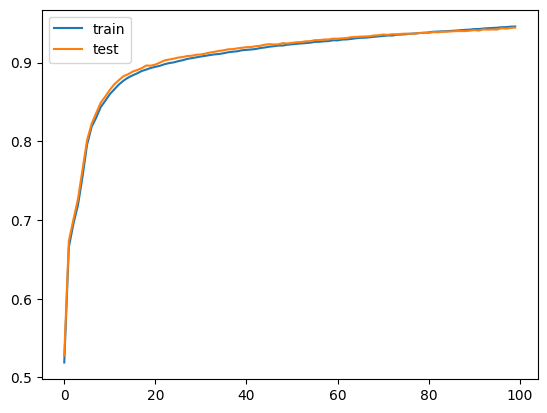

In [29]:
plot_acc(train_accuracy, test_accuracy)

성능이 엄청나게 좋아진 걸 확인할 수 있었다
예상대로 relu가 음수를 없애서 그런건지 멘토링 시간에 물어봐야겠다.